<a href="https://colab.research.google.com/github/jimba10/new/blob/main/Copy_of_Copy_1of_LondonEnergyUsage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [50]:
%cd /content/drive/MyDrive/LondonEnergyUsage/
# !unzip /content/drive/MyDrive/LondonEnergyUsage/PartitionedLCLData.zip

/content/drive/.shortcut-targets-by-id/1zJdqmWR-pV1ExxCTTdxWSvWKUWB1qoMu/LondonEnergyUsage


In [51]:
from tqdm import tqdm
import time
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, mean_squared_error
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingRegressor

In [52]:
def format_timeseries_data(folder_directory="Small LCL Data"):

  # Dataframe list
  dataframe_list = []

  # Loop through csv files
  for file in tqdm(os.listdir(folder_directory)):

    # Check if file follows expected naming convention
    if file.startswith('LCL') and file.endswith("csv"):

      # read CSV file
      data = pd.read_csv("Small LCL Data/" + file)

      # Filter data to datatime and Energy Consumption
      data = data.loc[:,['DateTime', 'KWH/hh (per half hour) ']]

      # Replace Null string as NaN
      data.replace('Null', np.nan, inplace=True)

      # Cast Energy Consumption to float
      data['KWH/hh (per half hour) '] = data['KWH/hh (per half hour) '].astype(float)

      # Convert 'timestamp' column to datetime format
      data['DateTime'] = pd.to_datetime(data['DateTime'])

      # Convert 'DateTime' column to hourly format
      data['DateTime'] = data['DateTime'].dt.to_period('H')

      # Group data by hourly records
      data = data.groupby('DateTime').mean()

      # Rename column to reflect monthly consumption
      data.rename(columns={"KWH/hh (per half hour) ":"KWH/h"}, inplace=True)

      # Reset index
      data.reset_index(inplace=True)

      # Append dataframe to list
      dataframe_list.append(data)

  # Concatenate dataframes
  df = pd.concat(dataframe_list, ignore_index=True)

  # Group data by month records
  df = df.groupby('DateTime', as_index=False).mean()

  return df

In [53]:
#df = format_timeseries_data(folder_directory="Small LCL Data")
#df.to_csv("energy_consumption_2011_2014.csv", index=False)

In [54]:
!gdown --id 13FvcpWIORxlkTDHDab88t_kQ7lwNxMUm

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=13FvcpWIORxlkTDHDab88t_kQ7lwNxMUm
To: /content/drive/.shortcut-targets-by-id/1zJdqmWR-pV1ExxCTTdxWSvWKUWB1qoMu/LondonEnergyUsage/energy_consumption_2011_2014.csv
100% 727k/727k [00:00<00:00, 91.1MB/s]


#### Visualization

In [55]:
df = pd.read_csv("energy_consumption_2011_2014.csv")

In [56]:
# Convert the 'DateTime' column to datetime format
df['DateTime'] = pd.to_datetime(df['DateTime'])

In [57]:
# Convert 'DateTime' column to month-year format
df['Year'] = df['DateTime'].dt.year
df['MonthYear'] = df['DateTime'].dt.to_period('M')
df['DayMonthYear'] = df['DateTime'].dt.to_period('D')

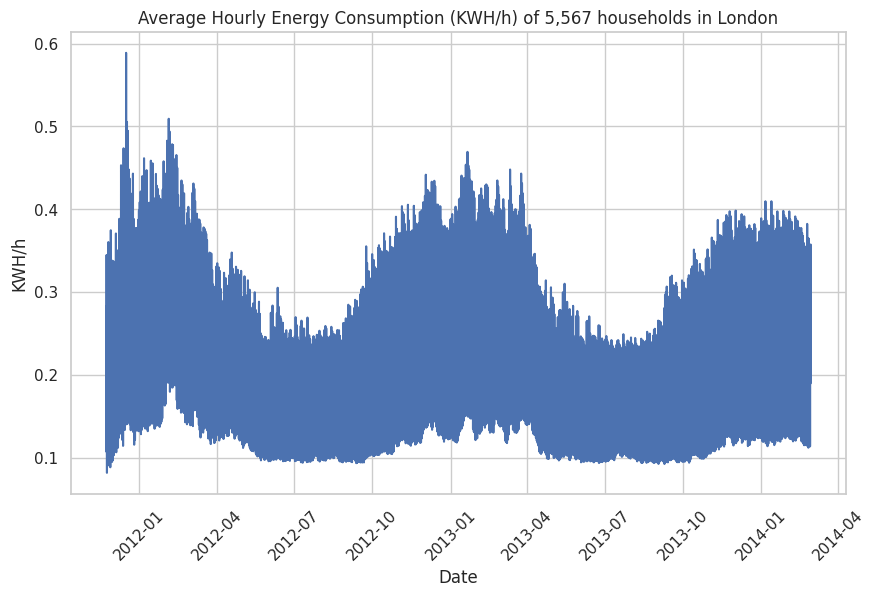

In [58]:
# Set style
sns.set(style="whitegrid")

# Create a figure and axis
plt.figure(figsize=(10, 6))

# Create the plot using Seaborn's lineplot function
sns.lineplot(data=df, x='DateTime', y='KWH/h')

# Customize the plot
plt.title('Average Hourly Energy Consumption (KWH/h) of 5,567 households in London')
plt.xlabel('Date')
plt.ylabel('KWH/h')

# Rotate x-axis labels for better visibility (optional)
plt.xticks(rotation=45)

# Show the plot
plt.show()

<ipython-input-59-dc65435d502a>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_chart = df.groupby('DayMonthYear', as_index=False).sum()


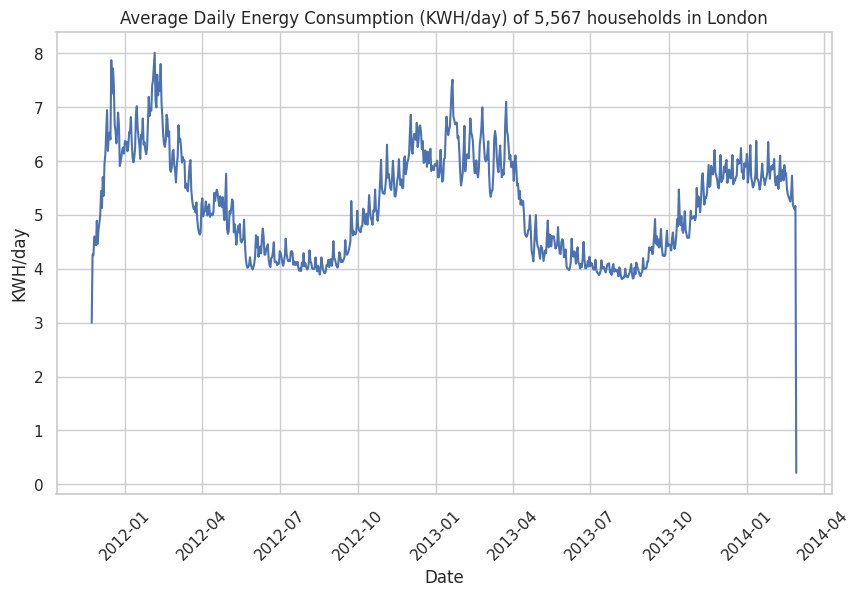

In [59]:
df_chart = df.groupby('DayMonthYear', as_index=False).sum()
df_chart['DayMonthYear'] = df_chart['DayMonthYear'].dt.to_timestamp()

# Set style
sns.set(style="whitegrid")

# Create a figure and axis
plt.figure(figsize=(10, 6))

# Create the plot using Seaborn's lineplot function
sns.lineplot(data=df_chart, x='DayMonthYear', y='KWH/h')

# Customize the plot
plt.title('Average Daily Energy Consumption (KWH/day) of 5,567 households in London')
plt.xlabel('Date')
plt.ylabel('KWH/day')

# Rotate x-axis labels for better visibility (optional)
plt.xticks(rotation=45)

# Show the plot
plt.show()

<ipython-input-60-25a942139fad>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_chart = df.groupby('MonthYear', as_index=False).sum()


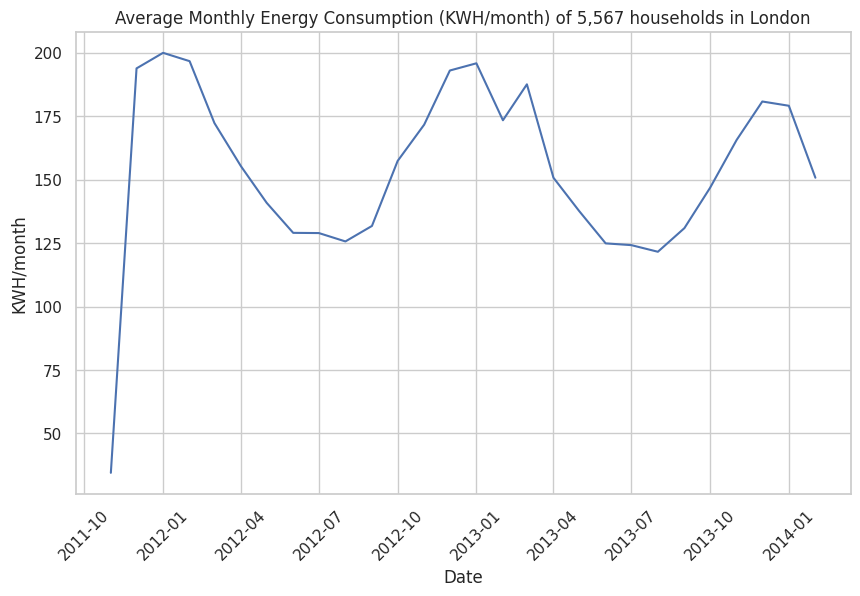

In [60]:
df_chart = df.groupby('MonthYear', as_index=False).sum()
df_chart['MonthYear'] = df_chart['MonthYear'].dt.to_timestamp()

# Set style
sns.set(style="whitegrid")

# Create a figure and axis
plt.figure(figsize=(10, 6))

# Create the plot using Seaborn's lineplot function
sns.lineplot(data=df_chart, x='MonthYear', y='KWH/h')

# Customize the plot
plt.title('Average Monthly Energy Consumption (KWH/month) of 5,567 households in London')
plt.xlabel('Date')
plt.ylabel('KWH/month')

# Rotate x-axis labels for better visibility (optional)
plt.xticks(rotation=45)

# Show the plot
plt.show()

<ipython-input-61-148b96502f02>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_chart = df.groupby('Year', as_index=False).sum()


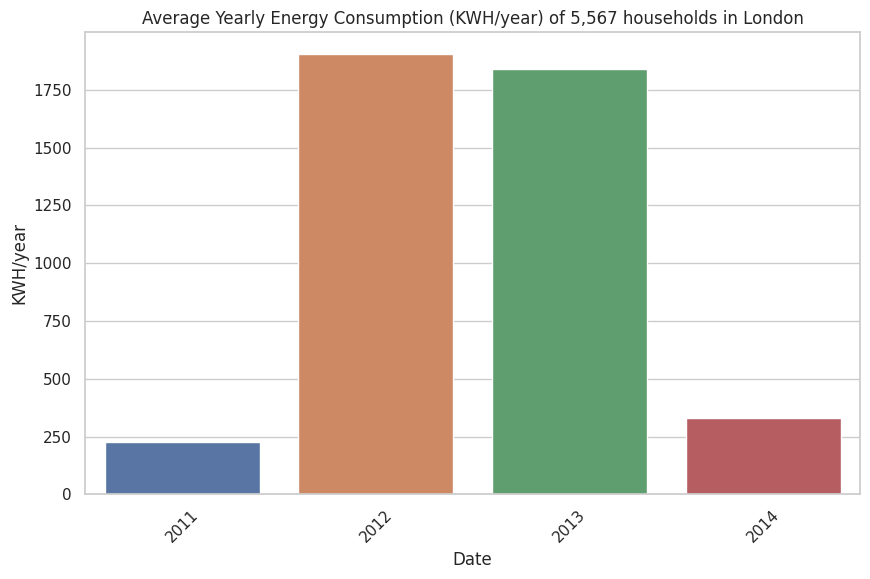

In [61]:
df_chart = df.groupby('Year', as_index=False).sum()

# Set style
sns.set(style="whitegrid")

# Create a figure and axis
plt.figure(figsize=(10, 6))

# Create the plot using Seaborn's lineplot function
sns.barplot(data=df_chart, x='Year', y='KWH/h')

# Customize the plot
plt.title('Average Yearly Energy Consumption (KWH/year) of 5,567 households in London')
plt.xlabel('Date')
plt.ylabel('KWH/year')

# Rotate x-axis labels for better visibility (optional)
plt.xticks(rotation=45)

# Show the plot
plt.show()

#### Consumption Pattern

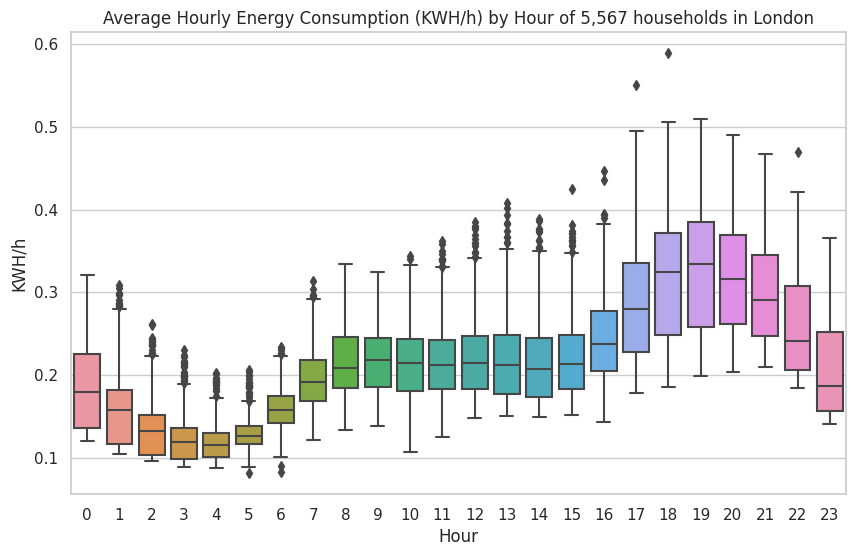

In [62]:
df_chart = df.copy()
df_chart['hour'] = df_chart['DateTime'].dt.hour

# Set style
sns.set(style="whitegrid")

# Create a figure and axis
plt.figure(figsize=(10, 6))

# Create the plot using Seaborn's lineplot function
sns.boxplot(data=df_chart, x='hour', y='KWH/h')

# Customize the plot
plt.title('Average Hourly Energy Consumption (KWH/h) by Hour of 5,567 households in London')
plt.xlabel('Hour')
plt.ylabel('KWH/h')

# Rotate x-axis labels for better visibility (optional)
plt.xticks(rotation=0)

# Show the plot
plt.show()

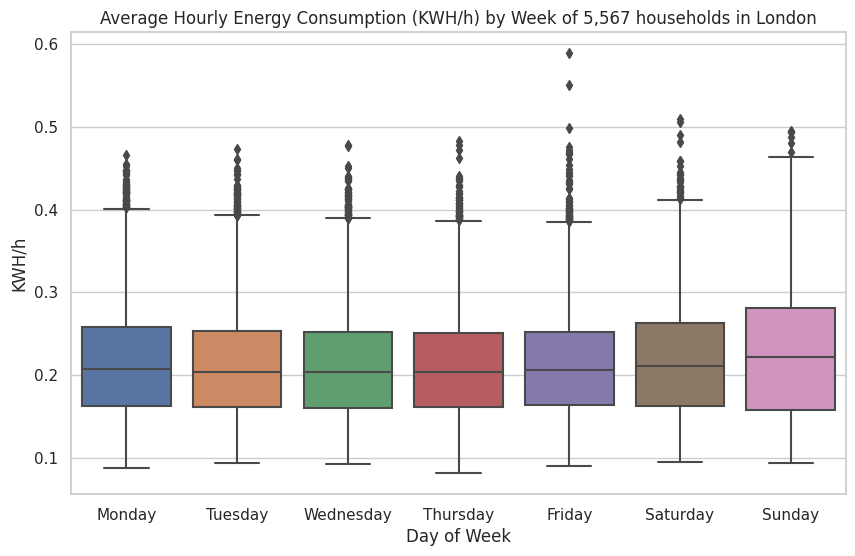

In [63]:
df_chart = df.copy()
# Map day of week numeric values to actual day names
day_of_week_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_chart['day_of_week'] = df_chart['DateTime'].dt.dayofweek.map(lambda x: day_of_week_names[x])

# Set style
sns.set(style="whitegrid")

# Create a figure and axis
plt.figure(figsize=(10, 6))

# Create the plot using Seaborn's lineplot function
sns.boxplot(data=df_chart, x='day_of_week', y='KWH/h', order=day_of_week_names)

# Customize the plot
plt.title('Average Hourly Energy Consumption (KWH/h) by Week of 5,567 households in London')
plt.xlabel('Day of Week')
plt.ylabel('KWH/h')

# Rotate x-axis labels for better visibility (optional)
plt.xticks(rotation=0)

# Show the plot
plt.show()

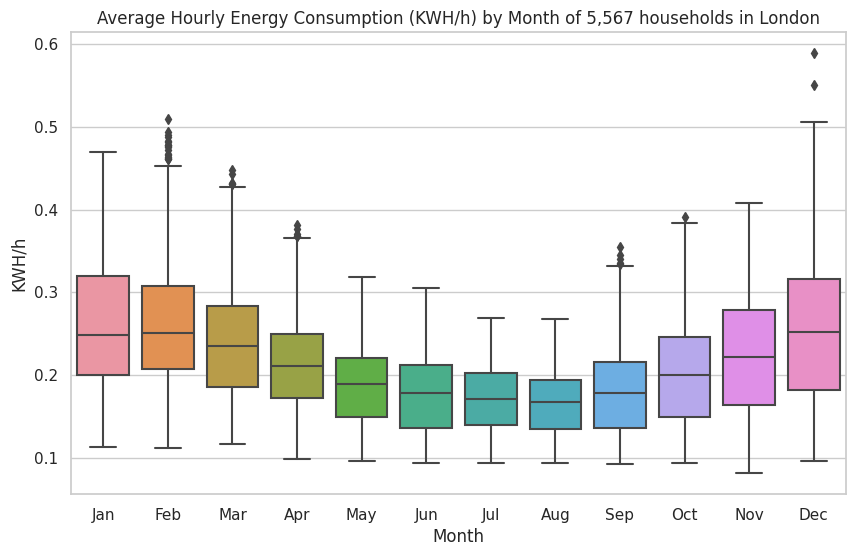

In [64]:
df_chart = df.copy()
# Map day of week numeric values to actual day names
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
df_chart['Month'] = df_chart['DateTime'].dt.month.map(lambda x: months[x-1])

# Set style
sns.set(style="whitegrid")

# Create a figure and axis
plt.figure(figsize=(10, 6))

# Create the plot using Seaborn's lineplot function
sns.boxplot(data=df_chart, x='Month', y='KWH/h', order=months)

# Customize the plot
plt.title('Average Hourly Energy Consumption (KWH/h) by Month of 5,567 households in London')
plt.xlabel('Month')
plt.ylabel('KWH/h')

# Rotate x-axis labels for better visibility (optional)
plt.xticks(rotation=0)

# Show the plot
plt.show()

<ipython-input-65-418fb90bc2ac>:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  hourly_avg = df_chart.resample('H').mean()


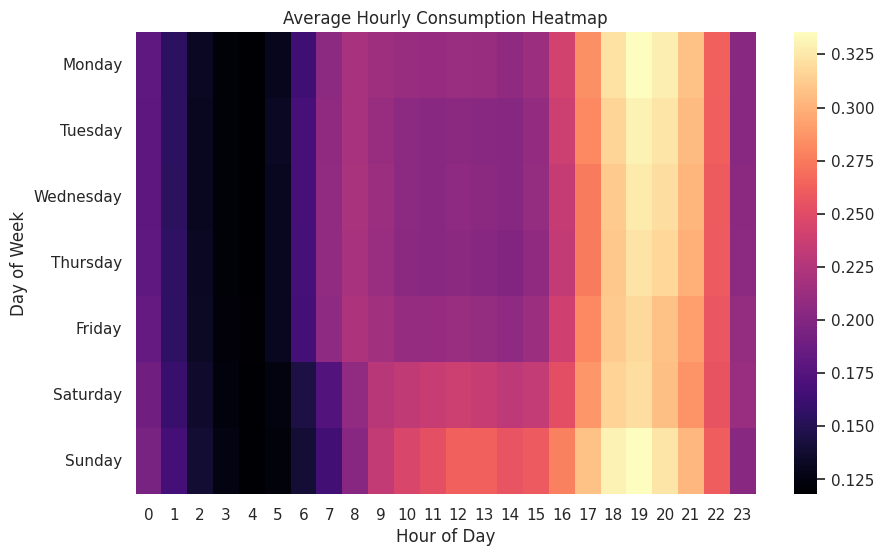

In [65]:
df_chart = df.copy()

# Convert the 'DateTime' column to datetime format
df_chart['DateTime'] = pd.to_datetime(df_chart['DateTime'])

# Set 'DateTime' as the index
df_chart.set_index('DateTime', inplace=True)

# Calculate the hourly average consumption
hourly_avg = df_chart.resample('H').mean()

# Reset index to extract DayOfWeek and Hour
hourly_avg.reset_index(inplace=True)

# Extract DayOfWeek and Hour
hourly_avg['DayOfWeek'] = hourly_avg['DateTime'].dt.strftime('%A')  # Full day name
hourly_avg['Hour'] = hourly_avg['DateTime'].dt.hour

# Create a pivot table with average consumption
hourly_avg_pivot = hourly_avg.pivot_table(index='DayOfWeek', columns='Hour', values='KWH/h', aggfunc='mean')

# Reorder the days of the week
days_of_week_reordered = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
hourly_avg_pivot = hourly_avg_pivot.reindex(days_of_week_reordered)

# Set up the figure and axes
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

# Create the heatmap using Seaborn's heatmap function
sns.heatmap(hourly_avg_pivot, cmap="magma", fmt=".1f")

# Customize the plot
plt.title('Average Hourly Consumption Heatmap')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')

# Show the plot
plt.show()

#### Modelling

In [66]:
df = pd.read_csv("energy_consumption_2011_2014.csv")

In [67]:
# Convert the 'DateTime' column to datetime format
df['DateTime'] = pd.to_datetime(df['DateTime'])
df.set_index('DateTime', inplace=True)

In [68]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    df['weekofyear'] = df['weekofyear'].astype(int)
    return df

def add_lags(df):
  target_map = df['KWH/h'].to_dict()
  df['lag1'] = (df.index - pd.Timedelta('30 days')).map(target_map)
  df['lag2'] = (df.index - pd.Timedelta('180 days')).map(target_map)
  df['lag3'] = (df.index - pd.Timedelta('364 days')).map(target_map)

  return df

In [69]:
df = create_features(df)
df = add_lags(df)

In [70]:
df

,KWH/h,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3
DateTime,,,,,,,,,,,,
2011-11-23 09:00:00,0.282500,9,2,4,11,2011,327,23,47,NaN,NaN,NaN
2011-11-23 10:00:00,0.107208,10,2,4,11,2011,327,23,47,NaN,NaN,NaN
2011-11-23 11:00:00,0.124767,11,2,4,11,2011,327,23,47,NaN,NaN,NaN
2011-11-23 12:00:00,0.240311,12,2,4,11,2011,327,23,47,NaN,NaN,NaN
2011-11-23 13:00:00,0.189738,13,2,4,11,2011,327,23,47,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2014-02-27 20:00:00,0.343292,20,3,1,2,2014,58,27,9,0.367736,0.234333,0.386014
2014-02-27 21:00:00,0.324589,21,3,1,2,2014,58,27,9,0.342636,0.218024,0.365418
2014-02-27 22:00:00,0.290134,22,3,1,2,2014,58,27,9,0.303409,0.185088,0.327896


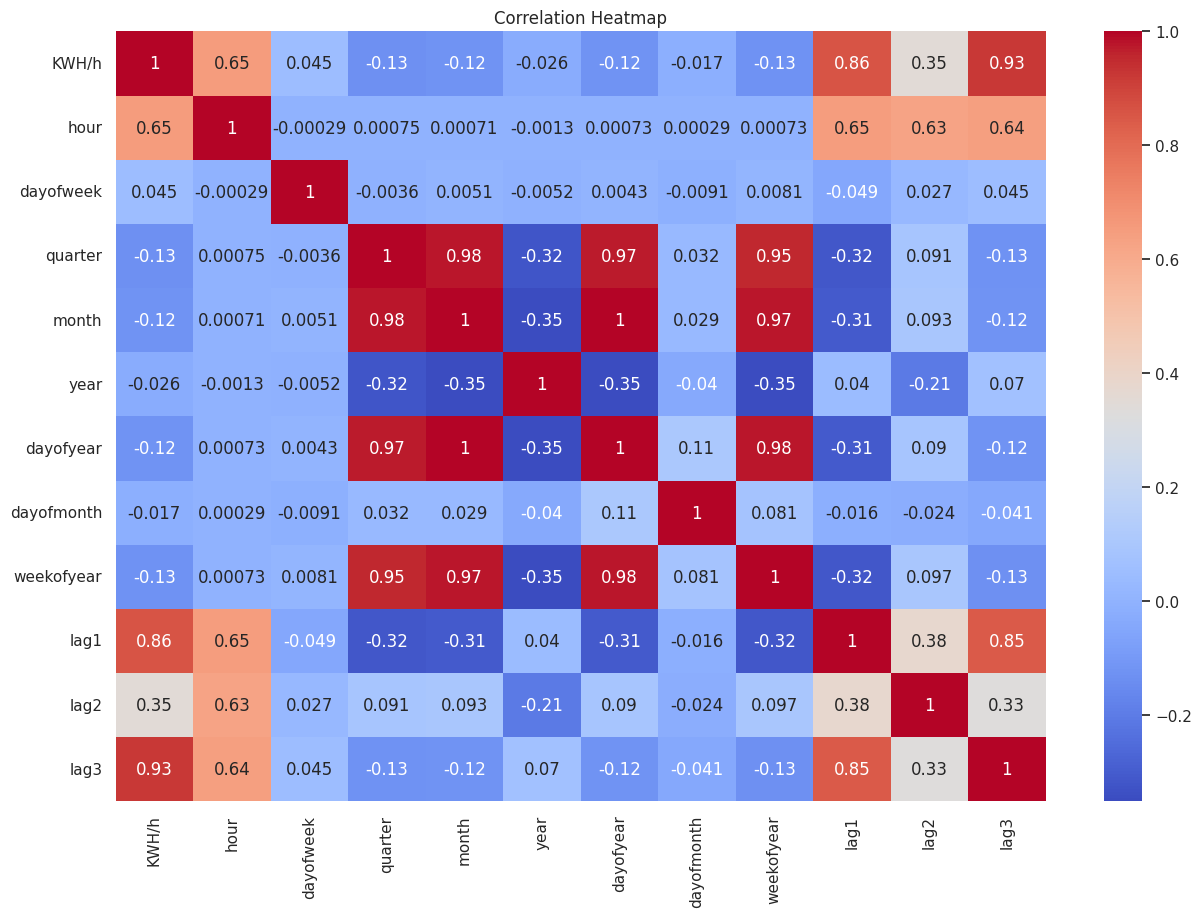

In [71]:
# Correlation heatmap:
corr = df.corr()
plt.figure(figsize=(15,10))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [72]:
df.reset_index(inplace=True)

In [73]:
df.describe()

,KWH/h,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3
count,19864.000000,19864.000000,19864.000000,19864.000000,19864.000000,19864.000000,19864.000000,19864.000000,19864.000000,19144.000000,15544.000000,11128.000000
mean,0.216574,11.502819,2.999295,2.471456,6.411951,2012.534585,180.073500,15.802910,26.034333,0.215931,0.215380,0.224753
std,0.076303,6.922176,1.998237,1.168264,3.690132,0.694562,112.891832,8.813939,16.071908,0.076306,0.076428,0.079378
min,0.081545,0.000000,0.000000,1.000000,1.000000,2011.000000,1.000000,1.000000,1.000000,0.081545,0.081545,0.081545
25%,0.161423,6.000000,1.000000,1.000000,3.000000,2012.000000,75.000000,8.000000,11.000000,0.161204,0.161557,0.166420
50%,0.208503,12.000000,3.000000,2.000000,6.000000,2013.000000,178.000000,16.000000,26.000000,0.207309,0.205327,0.215819
75%,0.259011,18.000000,5.000000,4.000000,10.000000,2013.000000,282.000000,23.000000,41.000000,0.258505,0.257010,0.269798
max,0.588896,23.000000,6.000000,4.000000,12.000000,2014.000000,366.000000,31.000000,52.000000,0.588896,0.588896,0.588896


In [74]:
X = df.drop(columns=["KWH/h", "DateTime"]) #features
X.fillna(0, inplace=True)
y = df[["KWH/h"]] #target

In [75]:
df.dtypes

DateTime      datetime64[ns]
KWH/h                float64
hour                   int64
dayofweek              int64
quarter                int64
month                  int64
year                   int64
dayofyear              int64
dayofmonth             int64
weekofyear             int64
lag1                 float64
lag2                 float64
lag3                 float64
dtype: object

In [91]:
# time series splitter
tscv = TimeSeriesSplit(n_splits=4)

In [92]:
r2_scores = []
mae_scores = []
rmse_scores = []

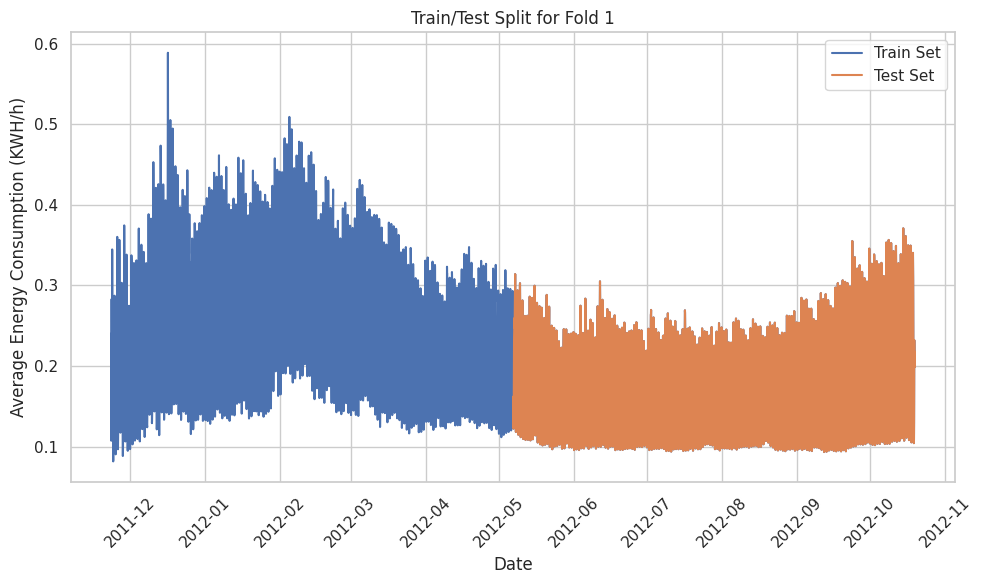

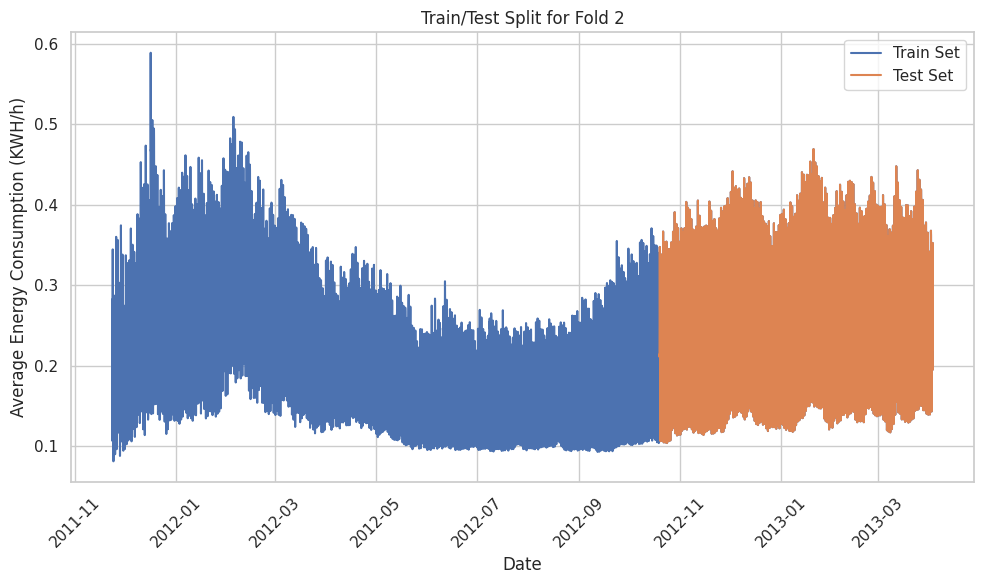

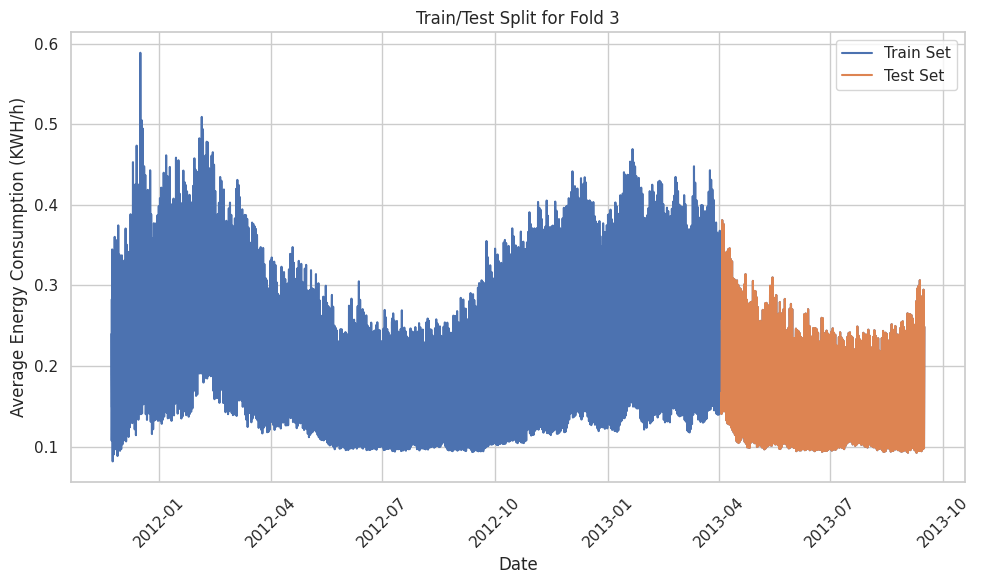

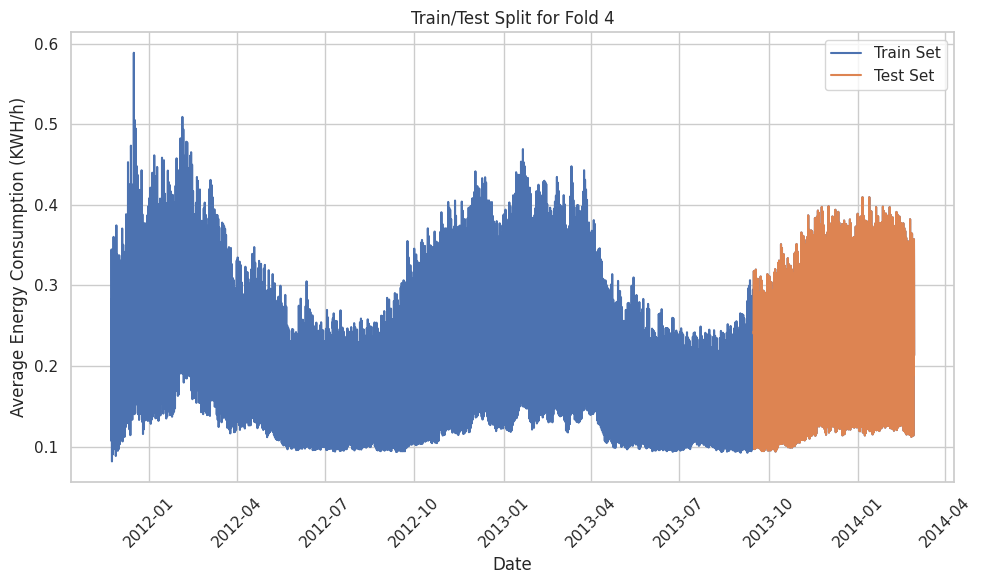

In [93]:
fold = 1
for train_idx, test_idx in tscv.split(X):
    plt.figure(figsize=(10, 6))
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    plt.plot(df.iloc[np.arange(len(y_train) + len(y_test))]['DateTime'], np.concatenate((y_train, y_test)), label='Train Set')

    # Plot predicted values, aligned with test data
    pred_start_index = len(y_train)  # Index to start plotting predicted values
    plt.plot(df.iloc[np.arange(pred_start_index, pred_start_index + len(y_test))]['DateTime'], y_test, label='Test Set')

    plt.xlabel('Date')
    plt.ylabel('Average Energy Consumption (KWH/h)')
    plt.title(f'Train/Test Split for Fold {fold}')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()
    fold+=1
    print("\n\n")

In [94]:
def train_lstm_model(X_train, y_train, X_test):
    X_train = np.asarray(X_train).astype(np.float32)
    y_train = np.asarray(y_train).astype(np.float32)
    X_test = np.asarray(X_test).astype(np.float32)
    lstm_model = Sequential()
    lstm_model.add(LSTM(units=50, input_shape=(X_train.shape[1], 1)))
    lstm_model.add(Dense(units=1))
    lstm_model.compile(optimizer='adam', loss='mse')
    lstm_model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=1)
    lstm_preds_tr = lstm_model.predict(X_train)
    lstm_preds = lstm_model.predict(X_test)
    return lstm_preds, lstm_preds_tr

def train_rf_model(X_train, y_train, X_test):
    rf_model = RandomForestRegressor(random_state=42)
    rf_model.fit(X_train, y_train.values.ravel())
    rf_preds_tr = rf_model.predict(X_train)
    rf_preds = rf_model.predict(X_test)
    return rf_preds, rf_preds_tr

def train_gbm_model(X_train, y_train, X_test):
    gbm_model = XGBRegressor(random_state=42)
    gbm_model.fit(X_train, y_train)
    gbm_preds_tr = gbm_model.predict(X_train)
    gbm_preds = gbm_model.predict(X_test)
    return gbm_preds, gbm_preds_tr

# Meta-learner model
def train_meta_learner(lstm_preds, lstm_preds_tr, rf_preds, rf_preds_tr, gbm_preds, gbm_preds_tr, y_train):
    meta_features_test = np.column_stack((lstm_preds, rf_preds, gbm_preds))
    meta_features_train = np.column_stack((lstm_preds_tr, rf_preds_tr, gbm_preds_tr))
    meta_learner = LinearRegression()
    meta_learner.fit(meta_features_train, y_train)
    stacking_preds = meta_learner.predict(meta_features_test)
    return stacking_preds

# Calculate performance metrics
def calculate_performance_metrics(y_true, y_preds):
    mse = mean_squared_error(y_true, y_preds, squared=False)
    return mse

In [ ]:
all_lstm_preds = []
lstm_mse_scores = []

all_rf_preds = []
rf_mse_scores = []

all_gbm_preds = []
gbm_mse_scores = []

all_stacked_preds = []
stacked_mse_scores = []

for train_idx, test_idx in tscv.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    print("LSTM model...")
    lstm_preds, lstm_preds_tr = train_lstm_model(X_train, y_train, X_test)
    all_lstm_preds.append(lstm_preds)
    mse = calculate_performance_metrics(y_test, lstm_preds)
    lstm_mse_scores.append(mse)

    print("Random Forest model...")
    rf_preds, rf_preds_tr = train_rf_model(X_train, y_train, X_test)
    all_rf_preds.append(rf_preds)
    mse = calculate_performance_metrics(y_test, rf_preds)
    rf_mse_scores.append(mse)

    print("XGBoost model...")
    gbm_preds, gbm_preds_tr = train_gbm_model(X_train, y_train, X_test)
    all_gbm_preds.append(gbm_preds)
    mse = calculate_performance_metrics(y_test, gbm_preds)
    gbm_mse_scores.append(mse)

    print("Meta model...")
    stacking_preds = train_meta_learner(lstm_preds, lstm_preds_tr, rf_preds, rf_preds_tr, gbm_preds, gbm_preds_tr, y_train)
    all_stacked_preds.append(stacking_preds)
    mse = calculate_performance_metrics(y_test, stacking_preds)
    stacked_mse_scores.append(mse)

LSTM model...
Epoch 1/5
125/125 [==============================] - 3s 8ms/step - loss: 0.0117
Epoch 2/5
125/125 [==============================] - 1s 8ms/step - loss: 0.0043
Epoch 3/5
125/125 [==============================] - 1s 7ms/step - loss: 0.0032
Epoch 4/5
125/125 [==============================] - 1s 11ms/step - loss: 0.0028
Epoch 5/5
125/125 [==============================] - 0s 3ms/step
Random Forest model...
XGBoost model...
Meta model...
LSTM model...
Epoch 1/5
249/249 [==============================] - 4s 8ms/step - loss: 0.0046
Epoch 2/5
249/249 [==============================] - 2s 9ms/step - loss: 0.0021
Epoch 3/5
249/249 [==============================] - 3s 13ms/step - loss: 0.0020
Epoch 4/5
249/249 [==============================] - 3s 11ms/step - loss: 0.0019
Epoch 5/5
125/125 [==============================] - 0s 3ms/step
Random Forest model...
XGBoost model...
Meta model...
LSTM model...
Epoch 1/5
373/373 [==============================] - 7s 9ms/step - loss: 0.00

#### Error Analysis

In [ ]:
result = {}
result['LSTM'] = lstm_mse_scores
result['Random Forest'] = rf_mse_scores
result['XGBoost'] = gbm_mse_scores
result['MetaLearner'] = stacked_mse_scores
data = []

for fold in range(1, len(result)):
  for key, values in result.items():
    dic = {}
    dic['Algorithm'] = key
    dic['RMSE'] = values[fold-1]
    dic['Fold'] = fold
    data.append(dic)
result_score_df = pd.DataFrame(data)

In [ ]:
result_score_df

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Algorithm', y='RMSE', hue='Fold', data=result_score_df)
plt.xlabel('Algorithm')
plt.ylabel('RMSE (KW/h)')
plt.title('Algorithm RMSE Comparison')
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Algorithm', y='RMSE', hue='Fold', data=result_score_df[result_score_df['Algorithm']!='LSTM'])
plt.xlabel('Algorithm')
plt.ylabel('RMSE (KW/h)')
plt.title('Algorithm RMSE Comparison')
plt.show()

In [ ]:
predictor_names = ['LSTM', 'Random Forest', 'XGBoost', "MetaLearner"]

# Create a box plot
plt.figure(figsize=(10, 6))
plt.boxplot([-np.array(lstm_mse_scores), -np.array(rf_mse_scores), -np.array(gbm_mse_scores), -np.array(stacked_mse_scores)])
plt.xlabel('Algorithm')
plt.ylabel('RMSE (KW/h)')
plt.title('Algorithm RMSE Comparison')
# Set xtick labels to predictor names
plt.xticks(range(1, len(predictor_names) + 1), predictor_names)
plt.show()

In [ ]:
predictor_names = ['Random Forest', 'XGBoost', "MetaLearner"]

# Create a box plot
plt.figure(figsize=(10, 6))
plt.boxplot([-np.array(rf_mse_scores), -np.array(gbm_mse_scores), -np.array(stacked_mse_scores)])
plt.xlabel('Algorithm')
plt.ylabel('RMSE (KW/h)')
plt.title('Algorithm RMSE Performance Comparison')
# Set xtick labels to predictor names
plt.xticks(range(1, len(predictor_names) + 1), predictor_names)
plt.show()

In [ ]:
model_name = "LSTM"
preds = all_lstm_preds
fold = 1
for train_idx, test_idx in tscv.split(X):
    plt.figure(figsize=(10, 6))
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    plt.plot(df.iloc[np.concatenate((train_idx, test_idx))]['DateTime'], np.concatenate((y_train, y_test)), label='Actual')

    # Plot predicted values, aligned with test data
    pred_start_index = len(y_train)  # Index to start plotting predicted values
    plt.plot(df.iloc[test_idx]['DateTime'], preds[fold-1], label='Prediction')

    plt.xlabel('Date')
    plt.ylabel('Average Energy Consumption (KWH/h)')
    plt.title(f'{model_name} Actual vs Predicted for Fold {fold}')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()
    fold+=1
    print("\n\n")

In [ ]:
model_name = "Random Forest"
preds = all_rf_preds
fold = 1
for train_idx, test_idx in tscv.split(X):
    plt.figure(figsize=(10, 6))
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    plt.plot(df.iloc[np.concatenate((train_idx, test_idx))]['DateTime'], np.concatenate((y_train, y_test)), label='Actual')

    # Plot predicted values, aligned with test data
    pred_start_index = len(y_train)  # Index to start plotting predicted values
    plt.plot(df.iloc[test_idx]['DateTime'], preds[fold-1], label='Prediction')

    plt.xlabel('Date')
    plt.ylabel('Average Energy Consumption (KWH/h)')
    plt.title(f'{model_name} Actual vs Predicted for Fold {fold}')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()
    fold+=1
    print("\n\n")

In [ ]:
model_name = "XBBoost"
preds = all_gbm_preds
fold = 1
for train_idx, test_idx in tscv.split(X):
    plt.figure(figsize=(10, 6))
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    plt.plot(df.iloc[np.concatenate((train_idx, test_idx))]['DateTime'], np.concatenate((y_train, y_test)), label='Actual')

    # Plot predicted values, aligned with test data
    pred_start_index = len(y_train)  # Index to start plotting predicted values
    plt.plot(df.iloc[test_idx]['DateTime'], preds[fold-1], label='Prediction')

    plt.xlabel('Date')
    plt.ylabel('Average Energy Consumption (KWH/h)')
    plt.title(f'{model_name} Actual vs Predicted for Fold {fold}')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()
    fold+=1
    print("\n\n")

In [ ]:
model_name = "MetaLearner"
preds = all_stacked_preds
fold = 1
for train_idx, test_idx in tscv.split(X):
    plt.figure(figsize=(10, 6))
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    plt.plot(df.iloc[np.concatenate((train_idx, test_idx))]['DateTime'], np.concatenate((y_train, y_test)), label='Actual')

    # Plot predicted values, aligned with test data
    pred_start_index = len(y_train)  # Index to start plotting predicted values
    plt.plot(df.iloc[test_idx]['DateTime'], preds[fold-1], label='Prediction')

    plt.xlabel('Date')
    plt.ylabel('Average Energy Consumption (KWH/h)')
    plt.title(f'{model_name} Actual vs Predicted for Fold {fold}')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()
    fold+=1
    print("\n\n")